# Do you need psuedo labels?

# You might need a token for space itself? start and stop tokens?

Not implemented

1. https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention
2. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention

# Sentiment Classification model with test as well in train? Will increase the vocab size as well?

# * https://www.tensorflow.org/tutorials/text/transformer
# * https://pytorch.org/tutorials/beginner/transformer_tutorial.html

https://rubikscode.net/2019/08/05/transformer-with-python-and-tensorflow-2-0-attention-layers/

## Settings

In [1]:
# CONTROLS
MODEL_PREFIX = "V15"
MODEL_NUMBER = MODEL_PREFIX[-2:]
TRAIN_SPLIT_RATIO = 0.8

DROPOUT = 0.3
MIN_LR = 1e-6
MAX_LR = 1e-3
BATCH_SIZE = 1024
PREDICT_BATCH_SIZE = 2048
STEP_SIZE = 10
CLR_METHOD = "triangular" # exp_range, triangular, triangular2
NUM_EPOCHS = 300

## Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

import pickle, os, sys, re
from time import time, ctime

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply, MaxPooling1D, Layer
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tokenizers

%matplotlib inline

In [3]:
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [4]:
pd.set_option('display.max_colwidth', -1)
np.random.seed(54321)

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [5]:
print(ctime(time()))

Tue Apr 28 11:16:35 2020


## Import Data

In [6]:
df = pd.read_csv("../data/train.csv",
                 encoding="utf8")

print(pd.concat((df.dtypes, df.isna().sum()), axis=1))
print(df.shape)

# Counts of various columns
print({i:df[i].nunique() for i in df.columns})
print(df.describe()) #.astype(int)
df.head(2)

                    0  1
textID         object  0
text           object  1
selected_text  object  1
sentiment      object  0
(27481, 4)
{'textID': 27481, 'text': 27480, 'selected_text': 22463, 'sentiment': 3}
            textID  \
count   27481        
unique  27481        
top     3d88d89c9d   
freq    1            

                                                                                                                            text  \
count   27480                                                                                                                      
unique  27480                                                                                                                      
top     Hell of a lot to do. But they say you shouldn`t complain theese days. Who are 'they' and can 'they' help me in that case   
freq    1                                                                                                                          

       selected_tex

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative


In [7]:
test_df = pd.read_csv("../data/test.csv")
print(pd.concat((test_df.dtypes, test_df.isna().sum()), axis=1))
print(test_df.shape)

# Counts of various columns
print({i:test_df[i].nunique() for i in test_df.columns})
print(test_df.describe())
test_df.head(2)

                0  1
textID     object  0
text       object  0
sentiment  object  0
(3534, 3)
{'textID': 3534, 'text': 3534, 'sentiment': 3}
            textID  \
count   3534         
unique  3534         
top     0437867c21   
freq    1            

                                                                                               text  \
count   3534                                                                                          
unique  3534                                                                                          
top      hi ya demi! im glad ur back   http://twitpic.com/4vuuy i personally love the picture! haha   
freq    1                                                                                             

       sentiment  
count   3534      
unique  3         
top     neutral   
freq    1430      


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive


In [8]:
df.loc[df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,selected_text,sentiment
44,c77717b103,I love to! But I`m only available from 5pm. and where dear? Would love to help convert her vids.ï¿½,I love to!,positive
192,28dbada620,*phew* Will make a note in case anyone else runs into the same issueï¿½,*phew* Will make a note in case anyone else runs into the same issueï¿½,neutral


In [9]:
test_df.loc[test_df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,sentiment
145,7223fdccc2,tikcets are only ï¿½91...each...BUT I SO WANT TO GO,positive
618,43ad351369,"AHHH - Whatchu talkinï¿½ baby? HAHAHA I canï¿½t believe youu:O heh, actually I can. Life is worth taking risks... http://tumblr.com/xs81qy54s",positive


## Exploration

#### Sentiment count in training

In [10]:
pd.concat([df.groupby("sentiment")[["text"]].count(), test_df.groupby("sentiment")[["text"]].count()], axis=1)

,text,text
sentiment,,
negative,7781,1001
neutral,11117,1430
positive,8582,1103


## Preprocessing

#### Cleaning

In [11]:
# For traceability
df["original_index"] = df.index
test_df["original_index"] = test_df.index

In [12]:
anomalous_idxs = [18, 27, 32, 39, 48, 49, 64, 66, 84, 92, 102, 116, 129, 132, 134, 149, 160, 166, 168, 189, 196, 197, 210, 223, 247, 251, 260, 285, 295, 296, 297, 309, 349, 362, 366, 382, 396, 398, 406, 410, 425, 458, 460, 482, 492, 500, 504, 517, 533, 537, 543, 569, 573, 581, 604, 605, 608, 634, 636, 637, 639, 642, 665, 670, 674, 678, 685, 702, 707, 709, 710, 727, 737, 746, 751, 757, 768, 778, 787, 794, 804, 809, 853, 854, 856, 863, 871, 872, 912, 931, 937, 942, 950, 956, 957, 963, 992, 993, 999, 1001, 1011, 1012, 1036, 1039, 1057, 1062, 1076, 1077, 1083, 1096, 1105, 1116, 1117, 1122, 1134, 1137, 1150, 1159, 1199, 1200, 1209, 1217, 1264, 1271, 1280, 1283, 1298, 1300, 1303, 1319, 1327, 1342, 1360, 1363, 1365, 1372, 1374, 1376, 1382, 1393, 1416, 1417, 1420, 1447, 1454, 1468, 1472, 1513, 1515, 1518, 1531, 1548, 1558, 1567, 1580, 1588, 1605, 1623, 1648, 1649, 1657, 1659, 1661, 1665, 1672, 1674, 1678, 1683, 1693, 1696, 1713, 1723, 1728, 1739, 1747, 1754, 1798, 1806, 1808, 1814, 1822, 1828, 1830, 1835, 1850, 1857, 1860, 1866, 1888, 1901, 1902, 1929, 1938, 1940, 1987, 1994, 2003, 2004, 2008, 2011, 2023, 2054, 2056, 2065, 2068, 2083, 2086, 2094, 2106, 2113, 2124, 2125, 2136, 2139, 2145, 2168, 2180, 2181, 2187, 2213, 2225, 2227, 2230, 2239, 2273, 2279, 2286, 2288, 2298, 2323, 2324, 2335, 2343, 2359, 2364, 2371, 2385, 2388, 2392, 2398, 2401, 2404, 2410, 2415, 2421, 2430, 2438, 2439, 2440, 2444, 2445, 2448, 2470, 2478, 2489, 2499, 2505, 2515, 2520, 2559, 2574, 2576, 2589, 2598, 2600, 2640, 2643, 2650, 2671, 2679, 2696, 2699, 2706, 2716, 2718, 2731, 2743, 2749, 2750, 2785, 2787, 2789, 2805, 2809, 2825, 2838, 2856, 2888, 2898, 2903, 2923, 2925, 2931, 2933, 2942, 2957, 2961, 2986, 2995, 3034, 3068, 3075, 3077, 3080, 3088, 3089, 3096, 3097, 3101, 3121, 3147, 3160, 3161, 3176, 3182, 3187, 3211, 3225, 3234, 3257, 3263, 3267, 3281, 3290, 3295, 3317, 3319, 3325, 3333, 3359, 3364, 3369, 3374, 3390, 3399, 3400, 3411, 3424, 3473, 3475, 3476, 3479, 3492, 3499, 3504, 3509, 3517, 3519, 3532, 3553, 3578, 3588, 3590, 3593, 3598, 3605, 3606, 3607, 3622, 3634, 3669, 3672, 3678, 3682, 3685, 3694, 3708, 3720, 3729, 3750, 3755, 3784, 3794, 3798, 3801, 3806, 3807, 3813, 3826, 3834, 3872, 3886, 3895, 3903, 3925, 3937, 3946, 3962, 3969, 3998, 4031, 4047, 4053, 4074, 4091, 4093, 4100, 4108, 4113, 4119, 4143, 4148, 4163, 4164, 4183, 4196, 4254, 4260, 4265, 4307, 4308, 4309, 4312, 4318, 4325, 4327, 4328, 4329, 4344, 4347, 4369, 4371, 4377, 4384, 4402, 4404, 4405, 4407, 4412, 4421, 4422, 4437, 4455, 4457, 4471, 4473, 4479, 4483, 4486, 4514, 4532, 4537, 4542, 4543, 4545, 4550, 4554, 4563, 4575, 4576, 4591, 4595, 4631, 4636, 4637, 4639, 4654, 4655, 4704, 4706, 4714, 4718, 4724, 4729, 4735, 4747, 4749, 4750, 4764, 4800, 4814, 4841, 4842, 4844, 4864, 4866, 4869, 4875, 4891, 4908, 4918, 4924, 4928, 4933, 4943, 4946, 4947, 4956, 4968, 4980, 4994, 5009, 5011, 5038, 5056, 5079, 5083, 5101, 5133, 5167, 5173, 5174, 5188, 5189, 5196, 5197, 5213, 5218, 5229, 5241, 5245, 5258, 5279, 5290, 5294, 5297, 5308, 5317, 5331, 5342, 5343, 5353, 5355, 5356, 5358, 5379, 5385, 5386, 5399, 5418, 5433, 5436, 5450, 5456, 5466, 5489, 5504, 5509, 5510, 5530, 5542, 5560, 5583, 5603, 5607, 5618, 5620, 5624, 5626, 5678, 5697, 5712, 5725, 5751, 5757, 5775, 5785, 5799, 5822, 5832, 5836, 5844, 5895, 5902, 5904, 5913, 5918, 5938, 5939, 5961, 5984, 5990, 6025, 6031, 6033, 6060, 6077, 6084, 6090, 6113, 6131, 6134, 6151, 6152, 6176, 6203, 6229, 6230, 6248, 6261, 6277, 6289, 6296, 6304, 6308, 6317, 6319, 6321, 6335, 6338, 6343, 6353, 6356, 6360, 6377, 6382, 6395, 6404, 6425, 6433, 6468, 6474, 6475, 6476, 6477, 6510, 6528, 6540, 6574, 6580, 6582, 6593, 6609, 6627, 6628, 6633, 6635, 6650, 6656, 6657, 6670, 6673, 6676, 6677, 6679, 6686, 6702, 6724, 6740, 6745, 6759, 6801, 6804, 6830, 6833, 6834, 6842, 6859, 6871, 6875, 6878, 6880, 6885, 6896, 6934, 6939, 6948, 6950, 6958, 6970, 6979, 6987, 7010, 7017, 7024, 7040, 7099, 7107, 7112, 7136, 7147, 7149, 7158, 7184, 7225, 7227, 7251, 7274, 7288, 7305, 7306, 7308, 7331, 7344, 7355, 7373, 7407, 7408, 7409, 7410, 7423, 7436, 7438, 7442, 7444, 7450, 7469, 7473, 7479, 7487, 7492, 7506, 7513, 7521, 7528, 7530, 7546, 7567, 7581, 7582, 7597, 7599, 7602, 7632, 7635, 7636, 7642, 7662, 7663, 7701, 7752, 7758, 7765, 7769, 7778, 7780, 7788, 7801, 7816, 7818, 7831, 7836, 7837, 7849, 7893, 7895, 7896, 7922, 7927, 7945, 7948, 7968, 7997, 8003, 8005, 8010, 8030, 8049, 8051, 8052, 8059, 8060, 8085, 8094, 8142, 8143, 8151, 8153, 8161, 8169, 8170, 8196, 8208, 8212, 8215, 8224, 8235, 8241, 8249, 8250, 8276, 8282, 8285, 8286, 8288, 8289, 8299, 8314, 8338, 8343, 8345, 8349, 8373, 8379, 8390, 8397, 8399, 8407, 8427, 8428, 8432, 8439, 8442, 8444, 8484, 8493, 8497, 8500, 8507, 8510, 8534, 8546, 8559, 8569, 8579, 8588, 8594, 8604, 8617, 8620, 8624, 8631, 8638, 8661, 8671, 8674, 8687, 8691, 8696, 8706, 8720, 8729, 8749, 8756, 8758, 8769, 8774, 8780, 8800, 8803, 8809, 8815, 8827, 8830, 8875, 8902, 8906, 8910, 8917, 8919, 8922, 8951, 8954, 8968, 8985, 8986, 8991, 8999, 9014, 9034, 9050, 9057, 9063, 9070, 9088, 9098, 9112, 9113, 9122, 9127, 9140, 9155, 9157, 9169, 9179, 9190, 9216, 9223, 9226, 9264, 9272, 9281, 9297, 9300, 9303, 9322, 9354, 9361, 9374, 9377, 9381, 9385, 9400, 9403, 9419, 9422, 9425, 9428, 9436, 9442, 9449, 9454, 9456, 9458, 9470, 9482, 9496, 9500, 9535, 9539, 9541, 9554, 9556, 9560, 9565, 9574, 9594, 9605, 9610, 9631, 9632, 9660, 9689, 9691, 9696, 9708, 9710, 9712, 9725, 9726, 9734, 9742, 9753, 9770, 9789, 9799, 9801, 9812, 9817, 9836, 9839, 9850, 9852, 9881, 9882, 9891, 9906, 9912, 9920, 9922, 9928, 9976, 9980, 9984, 10002, 10004, 10007, 10029, 10039, 10042, 10050, 10052, 10057, 10067, 10070, 10092, 10093, 10123, 10131, 10138, 10145, 10151, 10164, 10167, 10170, 10179, 10184, 10185, 10190, 10197, 10200, 10211, 10218, 10219, 10222, 10228, 10245, 10247, 10255, 10259, 10276, 10293, 10298, 10299, 10306, 10319, 10327, 10342, 10348, 10377, 10379, 10449, 10465, 10469, 10492, 10504, 10505, 10508, 10521, 10528, 10529, 10530, 10570, 10573, 10577, 10578, 10597, 10611, 10639, 10651, 10666, 10672, 10675, 10690, 10706, 10711, 10738, 10742, 10747, 10749, 10779, 10782, 10783, 10795, 10813, 10849, 10852, 10853, 10884, 10885, 10888, 10892, 10901, 10914, 10918, 10919, 10933, 10935, 10956, 10966, 10968, 10970, 10981, 10986, 10996, 10999, 11005, 11032, 11038, 11051, 11055, 11060, 11067, 11097, 11102, 11155, 11157, 11159, 11162, 11167, 11176, 11187, 11215, 11222, 11228, 11230, 11257, 11263, 11265, 11274, 11286, 11289, 11297, 11300, 11308, 11323, 11337, 11339, 11341, 11347, 11349, 11353, 11371, 11381, 11386, 11426, 11431, 11448, 11449, 11474, 11480, 11500, 11507, 11553, 11562, 11582, 11588, 11594, 11612, 11616, 11618, 11636, 11643, 11650, 11658, 11666, 11679, 11683, 11693, 11695, 11698, 11699, 11706, 11716, 11723, 11730, 11732, 11741, 11745, 11780, 11794, 11798, 11808, 11812, 11828, 11829, 11837, 11840, 11841, 11844, 11849, 11853, 11854, 11855, 11861, 11862, 11872, 11875, 11878, 11886, 11890, 11899, 11905, 11912, 11938, 11963, 11967, 11973, 11980, 11985, 11999, 12026, 12027, 12029, 12039, 12054, 12067, 12115, 12124, 12134, 12136, 12138, 12150, 12187, 12205, 12206, 12224, 12242, 12258, 12269, 12277, 12283, 12295, 12305, 12314, 12322, 12331, 12333, 12334, 12350, 12355, 12356, 12360, 12370, 12372, 12389, 12395, 12396, 12397, 12405, 12410, 12416, 12429, 12439, 12440, 12442, 12446, 12474, 12482, 12486, 12507, 12516, 12521, 12522, 12526, 12527, 12537, 12550, 12563, 12576, 12585, 12586, 12587, 12598, 12606, 12630, 12631, 12635, 12639, 12650, 12657, 12662, 12669, 12687, 12703, 12718, 12724, 12732, 12736, 12745, 12767, 12787, 12803, 12804, 12808, 12818, 12830, 12843, 12855, 12856, 12870, 12884, 12903, 12914, 12920, 12923, 12924, 12927, 12936, 12972, 12977, 12998, 13003, 13004, 13009, 13044, 13068, 13069, 13074, 13080, 13095, 13098, 13124, 13130, 13153, 13154, 13176, 13219, 13222, 13227, 13237, 13267, 13274, 13293, 13301, 13304, 13307, 13330, 13333, 13354, 13365, 13373, 13379, 13381, 13389, 13397, 13422, 13430, 13433, 13445, 13466, 13473, 13476, 13482, 13490, 13493, 13528, 13529, 13535, 13543, 13558, 13559, 13586, 13637, 13643, 13646, 13665, 13674, 13678, 13679, 13704, 13707, 13710, 13718, 13727, 13733, 13747, 13762, 13772, 13785, 13796, 13803, 13812, 13814, 13817, 13827, 13844, 13846, 13847, 13848, 13854, 13855, 13861, 13864, 13873, 13899, 13907, 13936, 13939, 13946, 13949, 13954, 13964, 13965, 13974, 13975, 13978, 13980, 14002, 14006, 14007, 14030, 14043, 14044, 14057, 14058, 14060, 14073, 14091, 14109, 14110, 14112, 14117, 14131, 14132, 14159, 14172, 14173, 14176, 14184, 14194, 14197, 14200, 14204, 14207, 14213, 14230, 14257, 14273, 14275, 14287, 14299, 14301, 14307, 14308, 14347, 14362, 14365, 14381, 14386, 14400, 14416, 14428, 14436, 14446, 14457, 14458, 14462, 14487, 14499, 14509, 14532, 14548, 14551, 14571, 14596, 14598, 14611, 14621, 14639, 14640, 14648, 14662, 14669, 14671, 14676, 14680, 14687, 14689, 14691, 14718, 14731, 14747, 14779, 14787, 14825, 14839, 14844, 14847, 14855, 14870, 14880, 14891, 14908, 14946, 14959, 14960, 14967, 14971, 14986, 15007, 15010, 15016, 15044, 15049, 15055, 15056, 15112, 15131, 15158, 15165, 15174, 15177, 15196, 15203, 15206, 15207, 15213, 15217, 15233, 15236, 15253, 15259, 15286, 15296, 15307, 15308, 15321, 15323, 15327, 15339, 15363, 15372, 15374, 15379, 15380, 15383, 15385, 15392, 15410, 15449, 15452, 15462, 15464, 15465, 15477, 15483, 15503, 15505, 15528, 15532, 15548, 15562, 15566, 15571, 15605, 15610, 15622, 15651, 15660, 15666, 15674, 15709, 15721, 15731, 15735, 15736, 15741, 15767, 15774, 15785, 15792, 15793, 15811, 15851, 15879, 15883, 15884, 15912, 15926, 15927, 15931, 15940, 15959, 15965, 15985, 15998, 16020, 16027, 16031, 16032, 16044, 16070, 16100, 16117, 16129, 16136, 16137, 16140, 16149, 16152, 16175, 16186, 16201, 16241, 16261, 16269, 16272, 16279, 16290, 16308, 16319, 16324, 16325, 16327, 16338, 16341, 16345, 16352, 16354, 16371, 16372, 16385, 16391, 16416, 16423, 16448, 16455, 16468, 16470, 16477, 16481, 16484, 16491, 16493, 16500, 16509, 16510, 16516, 16541, 16559, 16577, 16589, 16632, 16638, 16642, 16643, 16649, 16650, 16654, 16665, 16677, 16684, 16704, 16720, 16726, 16734, 16765, 16774, 16775, 16777, 16780, 16797, 16798, 16799, 16803, 16807, 16809, 16830, 16832, 16861, 16863, 16868, 16876, 16889, 16890, 16902, 16915, 16927, 16939, 16949, 16962, 16968, 17002, 17010, 17013, 17021, 17023, 17029, 17062, 17066, 17084, 17093, 17094, 17102, 17152, 17160, 17167, 17173, 17183, 17221, 17239, 17250, 17267, 17277, 17278, 17282, 17296, 17307, 17315, 17333, 17336, 17344, 17346, 17348, 17354, 17365, 17374, 17385, 17387, 17397, 17401, 17404, 17412, 17417, 17432, 17436, 17444, 17452, 17467, 17469, 17501, 17502, 17513, 17530, 17531, 17547, 17550, 17555, 17573, 17577, 17578, 17586, 17600, 17602, 17611, 17627, 17640, 17645, 17648, 17649, 17652, 17667, 17676, 17682, 17721, 17724, 17729, 17731, 17751, 17754, 17762, 17770, 17772, 17781, 17802, 17820, 17823, 17833, 17848, 17857, 17858, 17865, 17867, 17887, 17893, 17909, 17924, 17926, 17945, 17971, 17977, 17986, 17990, 18003, 18011, 18042, 18046, 18052, 18077, 18086, 18091, 18099, 18103, 18123, 18128, 18131, 18142, 18153, 18165, 18167, 18173, 18181, 18206, 18226, 18252, 18263, 18276, 18277, 18284, 18314, 18319, 18327, 18330, 18342, 18352, 18355, 18362, 18364, 18375, 18383, 18398, 18403, 18432, 18447, 18453, 18465, 18467, 18485, 18486, 18492, 18505, 18508, 18510, 18515, 18536, 18540, 18548, 18550, 18557, 18563, 18570, 18574, 18576, 18616, 18622, 18627, 18639, 18649, 18655, 18673, 18681, 18712, 18745, 18746, 18758, 18773, 18778, 18782, 18826, 18832, 18834, 18842, 18851, 18853, 18858, 18862, 18867, 18872, 18877, 18908, 18910, 18912, 18913, 18919, 18925, 18929, 18930, 18933, 18936, 18944, 18974, 18975, 18997, 19009, 19011, 19014, 19016, 19028, 19057, 19098, 19106, 19114, 19130, 19133, 19147, 19157, 19162, 19166, 19173, 19179, 19198, 19213, 19225, 19230, 19239, 19241, 19266, 19274, 19279, 19283, 19285, 19316, 19327, 19335, 19352, 19358, 19362, 19366, 19377, 19379, 19405, 19423, 19428, 19431, 19437, 19444, 19456, 19469, 19475, 19476, 19481, 19486, 19492, 19506, 19507, 19536, 19537, 19562, 19586, 19589, 19622, 19634, 19651, 19663, 19679, 19685, 19690, 19697, 19707, 19712, 19714, 19715, 19717, 19724, 19734, 19744, 19754, 19769, 19779, 19792, 19807, 19830, 19850, 19863, 19875, 19903, 19904, 19908, 19963, 19985, 19988, 20003, 20012, 20014, 20018, 20040, 20042, 20054, 20078, 20079, 20083, 20087, 20089, 20114, 20121, 20122, 20138, 20155, 20162, 20186, 20199, 20216, 20222, 20234, 20238, 20254, 20285, 20299, 20302, 20305, 20337, 20345, 20364, 20365, 20374, 20382, 20394, 20403, 20440, 20450, 20451, 20476, 20506, 20508, 20516, 20527, 20536, 20540, 20541, 20542, 20557, 20566, 20584, 20608, 20611, 20613, 20618, 20627, 20644, 20656, 20663, 20674, 20682, 20690, 20699, 20707, 20711, 20737, 20751, 20765, 20771, 20774, 20778, 20779, 20789, 20795, 20798, 20834, 20851, 20865, 20867, 20869, 20872, 20883, 20892, 20894, 20895, 20896, 20901, 20919, 20924, 20933, 20937, 20938, 20946, 20947, 20955, 20957, 20958, 20965, 20966, 20970, 20974, 20991, 21001, 21013, 21018, 21020, 21025, 21114, 21142, 21205, 21210, 21227, 21230, 21236, 21253, 21262, 21294, 21300, 21316, 21331, 21339, 21349, 21356, 21365, 21369, 21376, 21399, 21410, 21413, 21418, 21420, 21435, 21447, 21452, 21455, 21468, 21470, 21474, 21486, 21495, 21501, 21517, 21530, 21539, 21546, 21547, 21553, 21556, 21564, 21569, 21579, 21593, 21595, 21599, 21603, 21632, 21643, 21690, 21713, 21726, 21732, 21737, 21738, 21744, 21755, 21773, 21782, 21800, 21807, 21829, 21839, 21848, 21876, 21893, 21923, 21926, 21931, 21958, 21967, 21970, 21973, 21982, 22002, 22029, 22031, 22035, 22044, 22051, 22068, 22073, 22099, 22117, 22121, 22126, 22145, 22146, 22149, 22161, 22166, 22170, 22177, 22205, 22210, 22231, 22233, 22234, 22244, 22246, 22251, 22272, 22280, 22299, 22317, 22321, 22327, 22350, 22355, 22363, 22365, 22378, 22383, 22387, 22391, 22393, 22395, 22403, 22406, 22418, 22423, 22428, 22437, 22444, 22451, 22453, 22460, 22480, 22491, 22510, 22530, 22536, 22554, 22557, 22561, 22562, 22564, 22571, 22588, 22593, 22606, 22607, 22610, 22611, 22642, 22666, 22717, 22729, 22738, 22744, 22745, 22763, 22768, 22769, 22774, 22782, 22789, 22796, 22800, 22836, 22841, 22843, 22858, 22864, 22886, 22889, 22897, 22925, 22928, 22938, 22944, 22945, 22948, 22950, 22956, 22983, 22986, 22988, 22993, 22994, 22997, 23028, 23030, 23039, 23047, 23081, 23091, 23097, 23105, 23108, 23111, 23113, 23133, 23145, 23150, 23161, 23172, 23176, 23199, 23200, 23202, 23204, 23205, 23211, 23212, 23226, 23227, 23231, 23236, 23239, 23263, 23265, 23266, 23269, 23290, 23311, 23315, 23320, 23323, 23340, 23352, 23361, 23372, 23375, 23376, 23381, 23386, 23390, 23401, 23415, 23418, 23428, 23429, 23453, 23467, 23479, 23505, 23508, 23527, 23528, 23535, 23537, 23541, 23553, 23555, 23557, 23559, 23563, 23566, 23581, 23585, 23596, 23598, 23604, 23605, 23617, 23630, 23643, 23658, 23669, 23673, 23680, 23683, 23690, 23691, 23701, 23707, 23714, 23720, 23725, 23733, 23746, 23750, 23751, 23769, 23774, 23784, 23809, 23818, 23831, 23839, 23842, 23857, 23924, 23930, 23944, 23945, 23947, 23959, 23971, 23975, 23987, 23989, 24002, 24003, 24009, 24019, 24026, 24039, 24041, 24046, 24062, 24071, 24077, 24079, 24087, 24096, 24119, 24121, 24137, 24150, 24169, 24181, 24194, 24195, 24199, 24200, 24203, 24210, 24223, 24258, 24272, 24274, 24291, 24293, 24300, 24305, 24318, 24339, 24378, 24380, 24383, 24392, 24402, 24442, 24468, 24476, 24480, 24488, 24490, 24495, 24502, 24504, 24505, 24516, 24562, 24572, 24594, 24595, 24597, 24600, 24606, 24609, 24622, 24623, 24629, 24631, 24632, 24633, 24657, 24662, 24664, 24666, 24682, 24697, 24709, 24753, 24758, 24766, 24833, 24840, 24851, 24858, 24869, 24886, 24909, 24915, 24916, 24929, 24945, 24951, 24966, 24972, 24980, 24996, 25012, 25017, 25043, 25059, 25067, 25104, 25121, 25125, 25127, 25133, 25150, 25191, 25210, 25224, 25228, 25240, 25243, 25255, 25264, 25267, 25272, 25282, 25284, 25290, 25292, 25293, 25334, 25338, 25350, 25365, 25368, 25380, 25389, 25391, 25400, 25413, 25422, 25440, 25444, 25446, 25456, 25460, 25472, 25486, 25495, 25499, 25509, 25512, 25528, 25530, 25532, 25547, 25559, 25591, 25593, 25597, 25601, 25614, 25616, 25638, 25672, 25691, 25698, 25712, 25713, 25721, 25722, 25725, 25732, 25753, 25760, 25775, 25794, 25813, 25819, 25828, 25833, 25901, 25908, 25947, 25983, 25987, 25989, 25996, 26008, 26017, 26025, 26030, 26039, 26047, 26054, 26058, 26077, 26088, 26092, 26112, 26183, 26185, 26190, 26201, 26204, 26237, 26239, 26241, 26248, 26251, 26252, 26256, 26263, 26268, 26282, 26314, 26331, 26346, 26358, 26360, 26364, 26377, 26428, 26434, 26460, 26481, 26485, 26497, 26532, 26533, 26538, 26561, 26567, 26585, 26588, 26595, 26596, 26618, 26625, 26633, 26643, 26651, 26677, 26687, 26715, 26721, 26732, 26733, 26746, 26760, 26762, 26769, 26779, 26781, 26822, 26828, 26830, 26870, 26882, 26883, 26889, 26892, 26894, 26914, 26927, 26932, 26944, 26953, 26957, 26963, 26967, 26973, 26976, 26978, 26985, 27030, 27038, 27044, 27048, 27052, 27067, 27111, 27115, 27121, 27142, 27144, 27153, 27167, 27205, 27209, 27217, 27218, 27229, 27233, 27240, 27250, 27280, 27302, 27332, 27339, 27349, 27362, 27376, 27386, 27396, 27401, 27413, 27426, 27429, 27456, 27470, 27474, 27476, 27477, 27480]

In [13]:
print(df.shape)
df = df[(~df.index.isin(anomalous_idxs))]
print(df.shape)
df = df[(~df.text.isna())]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(27481, 5)
(24864, 5)
(24863, 5)


In [14]:
df["sentiment_code"] = df["sentiment"].astype("category")
X_sentiments = df["sentiment_code"].cat.codes.values

test_df["sentiment_code"] = test_df["sentiment"].astype("category")
X_sentiments_test = test_df["sentiment_code"].cat.codes.values

In [15]:
df["text"] = df["text"].astype(str)
df["selected_text"] = df["selected_text"].astype(str)
test_df["text"] = test_df["text"].astype(str)

In [16]:
df["text_mod"] = "xxxSTART " + df.text + " xxxSENTIMENT " + df.sentiment + " xxxEND"
test_df["text_mod"] = "xxxSTART " + test_df.text + " xxxSENTIMENT " + test_df.sentiment + " xxxEND"

#### Random Shuffle and Train Val Indices

In [17]:
n_rows = df.shape[0]
idx = [i for i in np.arange(n_rows)]
np.random.shuffle(idx)
train_idx, val_idx = idx[:round(TRAIN_SPLIT_RATIO * n_rows)], idx[round(TRAIN_SPLIT_RATIO * n_rows):]

print(len(idx), len(train_idx), len(val_idx), len(train_idx) + len(val_idx))

24863 19890 4973 24863


In [18]:
df["set_name"] = np.where(df.index.isin(val_idx), "val", "train")

In [19]:
df.groupby("set_name")["textID"].count()

set_name
train    19890
val      4973 
Name: textID, dtype: int64

#### Tokenization

In [20]:
if os.path.exists("../results/texts"):
    for i in os.listdir("../results/texts/"):
        os.remove("../results/texts/"+i)
else:
    os.mkdir("../results/texts/")

In [21]:
for i, j in zip(df.textID.loc[df.set_name=="train"], df.text_mod.loc[df.set_name=="train"]):
    with open("../results/texts/"+i+".txt", "w+") as f:
        f.write(j)

In [22]:
from pathlib import Path
paths = [str(x) for x in Path("../results/texts/").glob("**/*.txt")]

In [23]:
tokenizer = tokenizers.ByteLevelBPETokenizer(add_prefix_space=True, lowercase=True)

In [24]:
tokenizer.train(files=paths, min_frequency=2, show_progress=True, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "xxxSTART",
    "xxxSENTIMENT",
    "xxxEND"
])

In [25]:
tokenizer.save("../results/tokenizers/", MODEL_PREFIX)

['../results/tokenizers/V15-vocab.json',
 '../results/tokenizers/V15-merges.txt']

In [26]:
X_tokens = tokenizer.encode_batch(df.text_mod.tolist())
Y_tokens = tokenizer.encode_batch(df.selected_text.tolist())
X_tokens_test = tokenizer.encode_batch(test_df.text_mod.tolist())

In [27]:
X = [i.ids for i in X_tokens]
Y = [i.ids for i in Y_tokens]
X_test = [i.ids for i in X_tokens_test]

In [28]:
X_att = [i.attention_mask for i in X_tokens]
Y_att = [i.attention_mask for i in Y_tokens]
X_att_test = [i.attention_mask for i in X_tokens_test]

In [29]:
max_len = max([len(i) for i in X])
VOCAB_SIZE = tokenizer.get_vocab_size()
print(VOCAB_SIZE, max_len)

14517 108


In [30]:
def get_extremities(l_string, s_string, print_it=False):
    len_l = len(l_string)
    len_s = len(s_string)
    
    for i in range(len_l - len_s + 1):
        if (i + len_s) <= len_l:
            substring = l_string[i:i+len_s]
            if substring == s_string:
                if print_it:
                    print(l_string)
                    print(substring)
                    print(i, i+len_s, substring)
                
                start_vector, end_vector = [0] * len_l, [0] * len_l
                start_vector[i], end_vector[i+len_s-1] = 1, 1
                
                return (start_vector, end_vector)

In [31]:
Y_starts, Y_stops = [], []
anomaly_idx, counter = [], 0
for num, (i,j) in enumerate(zip(X_tokens, Y_tokens)):
    x,y = i.ids, j.ids
    #s,e = get_extremities(x, y)
    try:
        s,e = get_extremities(x, y)
    except TypeError as t:
        counter += 1
        anomaly_idx.append(num)
    Y_starts.append(s)
    Y_stops.append(e)
print(num + 1, "\t: #Processed")

print(counter,"\t: # of Anomalies")

24863 	: #Processed
1 	: # of Anomalies


In [32]:
print(anomaly_idx, sep=",")
df.iloc[anomaly_idx].tail(10)

[5001]


,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,set_name
5001,b507cce1a4,"I`m home, Yay! Unpacked everything, now just got to wash it all",Yay! Un,positive,5543,positive,"xxxSTART I`m home, Yay! Unpacked everything, now just got to wash it all xxxSENTIMENT positive xxxEND",val


In [33]:
check_idx = 201
print(df.text[check_idx])
print(df.selected_text[check_idx])
print([[i,j,k,l] for i,j,k,l in zip(X_tokens[check_idx].tokens,
                                    X_tokens[check_idx].ids,
                                    Y_starts[check_idx],
                                    Y_stops[check_idx])])
print([[i,j] for i,j in zip(Y_tokens[check_idx].ids,
                            Y_tokens[check_idx].tokens)])

failed inspection. Did you know you can pass wo/oven, but not wo/anti-tip bracket, which is only sold w/oven? This is worse than taxes.
This is worse than taxes.
[['xxxSTART', 4, 0, 0], ['Ġfailed', 2659, 0, 0], ['Ġinspection', 10359, 0, 0], ['.', 20, 0, 0], ['Ġdid', 510, 0, 0], ['Ġyou', 337, 0, 0], ['Ġknow', 497, 0, 0], ['Ġyou', 337, 0, 0], ['Ġcan', 405, 0, 0], ['Ġpass', 1581, 0, 0], ['Ġwo', 3752, 0, 0], ['/', 21, 0, 0], ['o', 85, 0, 0], ['ven', 603, 0, 0], [',', 18, 0, 0], ['Ġbut', 389, 0, 0], ['Ġnot', 400, 0, 0], ['Ġwo', 3752, 0, 0], ['/', 21, 0, 0], ['anti', 11245, 0, 0], ['-', 19, 0, 0], ['ti', 292, 0, 0], ['p', 86, 0, 0], ['Ġbracket', 12162, 0, 0], [',', 18, 0, 0], ['Ġwhich', 1286, 0, 0], ['Ġis', 349, 0, 0], ['Ġonly', 649, 0, 0], ['Ġsold', 2374, 0, 0], ['Ġw', 287, 0, 0], ['/', 21, 0, 0], ['o', 85, 0, 0], ['ven', 603, 0, 0], ['?', 37, 0, 0], ['Ġthis', 425, 1, 0], ['Ġis', 349, 0, 0], ['Ġworse', 2576, 0, 0], ['Ġthan', 445, 0, 0], ['Ġtaxes', 13510, 0, 0], ['.', 20, 0, 1], ['Ġ', 227, 0

#### Train Validation  split

In [34]:
X_train, X_val = [X[i] for i in train_idx], [X[i] for i in val_idx]
X_att_train, X_att_val = [X_att[i] for i in train_idx], [X_att[i] for i in val_idx]

Y_train, Y_val = [Y[i] for i in train_idx], [Y[i] for i in val_idx]
Y_starts_train, Y_starts_val = [Y_starts[i] for i in train_idx], [Y_starts[i] for i in val_idx]
Y_stops_train, Y_stops_val = [Y_stops[i] for i in train_idx], [Y_stops[i] for i in val_idx]

print("\n",
    len(X_train),"\t",": X_train","\n",
    len(X_att_train),"\t",": X_att_train","\n",
    len(Y_train),"\t",": Y_train","\n",
    len(Y_starts_train),"\t",": Y_starts_train","\n",
    len(Y_stops_train),"\t",": Y_stops_train","\n",
    len(X_val),"\t",": X_val","\n",
    len(X_att_val),"\t",": X_att_val","\n",
    len(Y_val),"\t",": Y_val","\n",
    len(Y_starts_val),"\t",": Y_starts_val","\n",
    len(Y_stops_val),"\t",": Y_stops_val","\n"
)


 19890 	 : X_train 
 19890 	 : X_att_train 
 19890 	 : Y_train 
 19890 	 : Y_starts_train 
 19890 	 : Y_stops_train 
 4973 	 : X_val 
 4973 	 : X_att_val 
 4973 	 : Y_val 
 4973 	 : Y_starts_val 
 4973 	 : Y_stops_val 



#### Padding

In [36]:
X_train = pad_sequences(X_train, maxlen=max_len, padding="post")
X_att_train = pad_sequences(X_att_train, maxlen=max_len, padding="post")
Y_train = pad_sequences(Y_train, maxlen=max_len, padding="post")
Y_starts_train = pad_sequences(Y_starts_train, maxlen=max_len, padding="post")
Y_stops_train = pad_sequences(Y_stops_train, maxlen=max_len, padding="post")

X_val = pad_sequences(X_val, maxlen=max_len, padding="post")
X_att_val = pad_sequences(X_att_val, maxlen=max_len, padding="post")
Y_val = pad_sequences(Y_val, maxlen=max_len, padding="post")
Y_starts_val = pad_sequences(Y_starts_val, maxlen=max_len, padding="post")
Y_stops_val = pad_sequences(Y_stops_val, maxlen=max_len, padding="post")

X_test = pad_sequences(X_test, maxlen=max_len, padding="post")
X_att_test = pad_sequences(X_att_test, maxlen=max_len, padding="post")

In [37]:
print("\n",
     X_train.shape, "\t: X_train ", "\n",
     X_att_train.shape, "\t: X_att_train ", "\n",
     Y_train.shape, "\t: Y_train ", "\n",
     Y_starts_train.shape, "\t: Y_starts_train ", "\n",
     Y_stops_train.shape, "\t: Y_stops_train ", "\n",

     X_val.shape, "\t: X_val ", "\n",
     X_att_val.shape, "\t: X_att_val ", "\n",
     Y_val.shape, "\t: Y_val ", "\n",
     Y_starts_val.shape, "\t: Y_starts_val ", "\n",
     Y_stops_val.shape, "\t: Y_stops_val ", "\n",

     X_test.shape, "\t: X_test ", "\n",
     X_att_test.shape, "\t: X_att_test ", "\n"
)


 (19890, 108) 	: X_train  
 (19890, 108) 	: X_att_train  
 (19890, 108) 	: Y_train  
 (19890, 108) 	: Y_starts_train  
 (19890, 108) 	: Y_stops_train  
 (4973, 108) 	: X_val  
 (4973, 108) 	: X_att_val  
 (4973, 108) 	: Y_val  
 (4973, 108) 	: Y_starts_val  
 (4973, 108) 	: Y_stops_val  
 (3534, 108) 	: X_test  
 (3534, 108) 	: X_att_test  



#### Checking for zero input vectors

In [38]:
print(np.argmax([X_train.sum(axis=1)==0]), np.min([X_train.sum(axis=1)]))
print(np.argmax([X_val.sum(axis=1)==0]), np.min([X_val.sum(axis=1)]))

0 1302
0 1562


#### Check inputs and outputs

In [39]:
#Train
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_train[num],
                                  X_att_train[num],
                                  Y_train[num],
                                  Y_starts_train[num],
                                  Y_stops_train[num])]

[[4, 1, 1066, 0, 0],
 [227, 1, 18, 0, 0],
 [1066, 1, 312, 1, 0],
 [18, 1, 1161, 0, 0],
 [312, 1, 598, 0, 0],
 [1161, 1, 642, 0, 0],
 [598, 1, 1219, 0, 0],
 [642, 1, 1960, 0, 0],
 [1219, 1, 595, 0, 0],
 [1960, 1, 20, 0, 0],
 [595, 1, 0, 0, 0],
 [20, 1, 0, 0, 1],
 [339, 1, 0, 0, 0],
 [2181, 1, 0, 0, 0],
 [436, 1, 0, 0, 0],
 [339, 1, 0, 0, 0],
 [403, 1, 0, 0, 0],
 [724, 1, 0, 0, 0],
 [793, 1, 0, 0, 0],
 [463, 1, 0, 0, 0],
 [389, 1, 0, 0, 0],
 [353, 1, 0, 0, 0],
 [1936, 1, 0, 0, 0],
 [339, 1, 0, 0, 0],
 [673, 1, 0, 0, 0],
 [70, 1, 0, 0, 0],
 [90, 1, 0, 0, 0],
 [18, 1, 0, 0, 0],
 [2947, 1, 0, 0, 0],
 [706, 1, 0, 0, 0],
 [18, 1, 0, 0, 0],
 [227, 1, 0, 0, 0],
 [5, 1, 0, 0, 0],
 [328, 1, 0, 0, 0],
 [227, 1, 0, 0, 0],
 [6, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 

In [40]:
#Val
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_val[num],
                                  X_att_val[num],
                                  Y_val[num],
                                  Y_starts_val[num],
                                  Y_stops_val[num])]

[[4, 1, 347, 0, 0],
 [227, 1, 482, 0, 0],
 [347, 1, 311, 1, 0],
 [482, 1, 0, 0, 0],
 [311, 1, 0, 0, 1],
 [227, 1, 0, 0, 0],
 [5, 1, 0, 0, 0],
 [309, 1, 0, 0, 0],
 [227, 1, 0, 0, 0],
 [6, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 

In [41]:
#Test
num = 100
[[i,j,k] for i,j,k in zip(X_tokens_test[num].ids,
                          X_test[num],
                          X_tokens_test[num].attention_mask)]

[[4, 4, 1],
 [3876, 3876, 1],
 [18, 18, 1],
 [2105, 2105, 1],
 [7, 7, 1],
 [282, 282, 1],
 [8781, 8781, 1],
 [353, 353, 1],
 [2105, 2105, 1],
 [7, 7, 1],
 [342, 342, 1],
 [339, 339, 1],
 [512, 512, 1],
 [350, 350, 1],
 [1113, 1113, 1],
 [647, 647, 1],
 [312, 312, 1],
 [495, 495, 1],
 [271, 271, 1],
 [1176, 1176, 1],
 [423, 423, 1],
 [342, 342, 1],
 [1882, 1882, 1],
 [7829, 7829, 1],
 [394, 394, 1],
 [793, 793, 1],
 [20, 20, 1],
 [227, 227, 1],
 [1945, 1945, 1],
 [1380, 1380, 1],
 [227, 227, 1],
 [5, 5, 1],
 [309, 309, 1],
 [227, 227, 1],
 [6, 6, 1]]

## Model

In [42]:
input_att_flags = Input((max_len), name="att_flags")
input_sequences = Input((max_len), name="words")

emb_sequences = Embedding(input_dim=VOCAB_SIZE, input_length=max_len, output_dim=64, mask_zero=True)(input_sequences)

seq = Bidirectional(LSTM(32, activation=None, return_sequences=True))(emb_sequences)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(32, activation=None, return_sequences=True))(seq)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(32, activation=None, return_sequences=False))(seq)
#seq = Attention(max_len)(seq)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Dense(max_len, activation="relu")(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

att = Dense(max_len, activation="relu")(input_att_flags)
att = BatchNormalization()(att)
att = Dropout(DROPOUT)(att)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(emb_sequences)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = MaxPooling1D(pool_size=2, strides=1)(convs)
convs = Dropout(DROPOUT)(convs)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = MaxPooling1D(pool_size=2, strides=1)(convs)
convs = Dropout(DROPOUT)(convs)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = MaxPooling1D(pool_size=2, strides=1)(convs)
convs = Dropout(DROPOUT)(convs)

convs = Flatten()(convs)
convs = Dense(max_len, activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = Dropout(DROPOUT)(convs)

conv = Multiply()([att, convs])
seq = Multiply()([att, seq])
concat_layer = concatenate([conv, seq])

output_starts = Dense(max_len, activation=None)(concat_layer)
output_starts = BatchNormalization()(output_starts)
output_starts = Activation("relu")(output_starts)
output_starts = Dropout(DROPOUT)(output_starts)

output_starts = Dense(max_len, activation=None)(output_starts)
output_starts = Activation("relu")(output_starts)

output_stops = Dense(max_len, activation=None)(concat_layer)
output_stops = BatchNormalization()(output_stops)
output_stops = Activation("relu")(output_stops)
output_stops = Dropout(DROPOUT)(output_stops)

output_stops = Dense(max_len, activation=None)(output_stops)
output_stops = Activation("relu")(output_stops)

output_starts = Dense(max_len, activation='softmax', name="starts")(output_starts)
output_stops = Dense(max_len, activation='softmax', name="stops")(output_stops)

In [43]:
model = Model([input_att_flags, input_sequences], [output_starts, output_stops])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 108)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 108, 64)      929088      words[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 108, 32)      16416       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 108, 32)      128         conv1d[0][0]                     
______________________________________________________________________________________________

In [44]:
adam = Adam(learning_rate=MIN_LR)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam , metrics=['accuracy'])

In [45]:
#callbacks
mcp = ModelCheckpoint(filepath="../results/"+MODEL_PREFIX+"BestCheckpoint.h5",
                      monitor='val_loss',
                      mode="auto",
                      save_weights_only=False,
                      save_best_only=True)

clr = CyclicLR(mode=CLR_METHOD,
               base_lr=MIN_LR,
               max_lr=MAX_LR,
               step_size= STEP_SIZE * (X_train.shape[0] // BATCH_SIZE))

In [46]:
history = model.fit(x={"att_flags":X_att_train,
                       "words":X_train},
                    y={"starts":Y_starts_train.argmax(axis=1),
                       "stops":Y_stops_train.argmax(axis=1)},
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=({"att_flags":X_att_val, "words":X_val},
                                     {"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)}),
                    verbose=1,
                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp,

Train on 19890 samples, validate on 4973 samples
Epoch 1/300
19890/19890 [==============================] - 33s 2ms/sample - loss: 9.3577 - starts_loss: 4.5575 - stops_loss: 4.7979 - starts_accuracy: 0.0762 - stops_accuracy: 0.0138 - val_loss: 9.3318 - val_starts_loss: 4.6548 - val_stops_loss: 4.6770 - val_starts_accuracy: 0.2286 - val_stops_accuracy: 0.0205
Epoch 2/300
19890/19890 [==============================] - 17s 848us/sample - loss: 9.0100 - starts_loss: 4.3396 - stops_loss: 4.6629 - starts_accuracy: 0.1553 - stops_accuracy: 0.0210 - val_loss: 9.2580 - val_starts_loss: 4.6007 - val_stops_loss: 4.6573 - val_starts_accuracy: 0.2737 - val_stops_accuracy: 0.0326
Epoch 3/300
19890/19890 [==============================] - 17s 838us/sample - loss: 8.2374 - starts_loss: 3.8241 - stops_loss: 4.3933 - starts_accuracy: 0.2777 - stops_accuracy: 0.0471 - val_loss: 9.0713 - val_starts_loss: 4.4658 - val_stops_loss: 4.6055 - val_starts_accuracy: 0.2972 - val_stops_accuracy: 0.0993
Epoch 4/300

Epoch 27/300
19890/19890 [==============================] - 17s 874us/sample - loss: 3.5985 - starts_loss: 1.9100 - stops_loss: 1.6895 - starts_accuracy: 0.3550 - stops_accuracy: 0.5662 - val_loss: 4.2790 - val_starts_loss: 2.2206 - val_stops_loss: 2.0554 - val_starts_accuracy: 0.3235 - val_stops_accuracy: 0.5317
Epoch 28/300
19890/19890 [==============================] - 17s 876us/sample - loss: 3.5829 - starts_loss: 1.9032 - stops_loss: 1.6771 - starts_accuracy: 0.3558 - stops_accuracy: 0.5713 - val_loss: 4.1746 - val_starts_loss: 2.2299 - val_stops_loss: 1.9421 - val_starts_accuracy: 0.3515 - val_stops_accuracy: 0.5443
Epoch 29/300
19890/19890 [==============================] - 17s 858us/sample - loss: 3.5905 - starts_loss: 1.9125 - stops_loss: 1.6761 - starts_accuracy: 0.3555 - stops_accuracy: 0.5731 - val_loss: 3.7645 - val_starts_loss: 2.0353 - val_stops_loss: 1.7267 - val_starts_accuracy: 0.3648 - val_stops_accuracy: 0.5771
Epoch 30/300
19890/19890 [=============================

19890/19890 [==============================] - 17s 843us/sample - loss: 3.0827 - starts_loss: 1.5652 - stops_loss: 1.5224 - starts_accuracy: 0.5811 - stops_accuracy: 0.5955 - val_loss: 3.1217 - val_starts_loss: 1.5724 - val_stops_loss: 1.5469 - val_starts_accuracy: 0.5874 - val_stops_accuracy: 0.6117
Epoch 54/300
19890/19890 [==============================] - 17s 853us/sample - loss: 3.0481 - starts_loss: 1.5448 - stops_loss: 1.5010 - starts_accuracy: 0.5849 - stops_accuracy: 0.5983 - val_loss: 3.0975 - val_starts_loss: 1.5560 - val_stops_loss: 1.5390 - val_starts_accuracy: 0.5998 - val_stops_accuracy: 0.6119
Epoch 55/300
19890/19890 [==============================] - 17s 876us/sample - loss: 3.0080 - starts_loss: 1.5221 - stops_loss: 1.4869 - starts_accuracy: 0.5891 - stops_accuracy: 0.6005 - val_loss: 3.1028 - val_starts_loss: 1.5594 - val_stops_loss: 1.5408 - val_starts_accuracy: 0.5996 - val_stops_accuracy: 0.6095
Epoch 56/300
19890/19890 [==============================] - 18s 907u

19890/19890 [==============================] - 17s 878us/sample - loss: 2.7382 - starts_loss: 1.3795 - stops_loss: 1.3598 - starts_accuracy: 0.6095 - stops_accuracy: 0.6167 - val_loss: 3.1145 - val_starts_loss: 1.5344 - val_stops_loss: 1.5766 - val_starts_accuracy: 0.6081 - val_stops_accuracy: 0.6051
Epoch 80/300
19890/19890 [==============================] - 17s 856us/sample - loss: 2.7258 - starts_loss: 1.3723 - stops_loss: 1.3541 - starts_accuracy: 0.6100 - stops_accuracy: 0.6164 - val_loss: 3.1115 - val_starts_loss: 1.5342 - val_stops_loss: 1.5739 - val_starts_accuracy: 0.6077 - val_stops_accuracy: 0.6077
Epoch 81/300
19890/19890 [==============================] - 17s 861us/sample - loss: 2.7216 - starts_loss: 1.3644 - stops_loss: 1.3568 - starts_accuracy: 0.6114 - stops_accuracy: 0.6175 - val_loss: 3.1266 - val_starts_loss: 1.5369 - val_stops_loss: 1.5864 - val_starts_accuracy: 0.6077 - val_stops_accuracy: 0.6043
Epoch 82/300
19890/19890 [==============================] - 16s 825u

19890/19890 [==============================] - 17s 867us/sample - loss: 2.5702 - starts_loss: 1.2966 - stops_loss: 1.2721 - starts_accuracy: 0.6160 - stops_accuracy: 0.6280 - val_loss: 3.4798 - val_starts_loss: 1.7129 - val_stops_loss: 1.7644 - val_starts_accuracy: 0.6043 - val_stops_accuracy: 0.6113
Epoch 106/300
19890/19890 [==============================] - 17s 855us/sample - loss: 2.5771 - starts_loss: 1.2989 - stops_loss: 1.2780 - starts_accuracy: 0.6161 - stops_accuracy: 0.6290 - val_loss: 3.2309 - val_starts_loss: 1.5370 - val_stops_loss: 1.6905 - val_starts_accuracy: 0.6055 - val_stops_accuracy: 0.6127
Epoch 107/300
19890/19890 [==============================] - 17s 852us/sample - loss: 2.5525 - starts_loss: 1.2920 - stops_loss: 1.2577 - starts_accuracy: 0.6187 - stops_accuracy: 0.6361 - val_loss: 3.2028 - val_starts_loss: 1.5432 - val_stops_loss: 1.6561 - val_starts_accuracy: 0.5974 - val_stops_accuracy: 0.6073
Epoch 108/300
19890/19890 [==============================] - 17s 8

Epoch 131/300
19890/19890 [==============================] - 17s 843us/sample - loss: 2.3883 - starts_loss: 1.2148 - stops_loss: 1.1698 - starts_accuracy: 0.6284 - stops_accuracy: 0.6452 - val_loss: 3.2838 - val_starts_loss: 1.6220 - val_stops_loss: 1.6573 - val_starts_accuracy: 0.5974 - val_stops_accuracy: 0.5898
Epoch 132/300
19890/19890 [==============================] - 17s 838us/sample - loss: 2.3682 - starts_loss: 1.2120 - stops_loss: 1.1499 - starts_accuracy: 0.6290 - stops_accuracy: 0.6545 - val_loss: 3.2532 - val_starts_loss: 1.5911 - val_stops_loss: 1.6578 - val_starts_accuracy: 0.5976 - val_stops_accuracy: 0.6004
Epoch 133/300
19890/19890 [==============================] - 17s 838us/sample - loss: 2.3655 - starts_loss: 1.2204 - stops_loss: 1.1515 - starts_accuracy: 0.6292 - stops_accuracy: 0.6503 - val_loss: 3.2502 - val_starts_loss: 1.5875 - val_stops_loss: 1.6583 - val_starts_accuracy: 0.5984 - val_stops_accuracy: 0.6008
Epoch 134/300
19890/19890 [=========================

Epoch 157/300
19890/19890 [==============================] - 17s 858us/sample - loss: 2.3019 - starts_loss: 1.1849 - stops_loss: 1.1147 - starts_accuracy: 0.6357 - stops_accuracy: 0.6631 - val_loss: 3.2803 - val_starts_loss: 1.6026 - val_stops_loss: 1.6737 - val_starts_accuracy: 0.5928 - val_stops_accuracy: 0.5966
Epoch 158/300
19890/19890 [==============================] - 17s 850us/sample - loss: 2.3002 - starts_loss: 1.1825 - stops_loss: 1.1171 - starts_accuracy: 0.6346 - stops_accuracy: 0.6570 - val_loss: 3.2838 - val_starts_loss: 1.6040 - val_stops_loss: 1.6758 - val_starts_accuracy: 0.5968 - val_stops_accuracy: 0.5962
Epoch 159/300
19890/19890 [==============================] - 17s 846us/sample - loss: 2.3238 - starts_loss: 1.1972 - stops_loss: 1.1255 - starts_accuracy: 0.6317 - stops_accuracy: 0.6530 - val_loss: 3.2593 - val_starts_loss: 1.5935 - val_stops_loss: 1.6622 - val_starts_accuracy: 0.6075 - val_stops_accuracy: 0.5990
Epoch 160/300
19890/19890 [=========================

Epoch 183/300
19890/19890 [==============================] - 17s 845us/sample - loss: 2.3997 - starts_loss: 1.2217 - stops_loss: 1.1796 - starts_accuracy: 0.6320 - stops_accuracy: 0.6489 - val_loss: 3.2240 - val_starts_loss: 1.5645 - val_stops_loss: 1.6553 - val_starts_accuracy: 0.5994 - val_stops_accuracy: 0.6002
Epoch 184/300
19890/19890 [==============================] - 17s 837us/sample - loss: 2.3670 - starts_loss: 1.2043 - stops_loss: 1.1622 - starts_accuracy: 0.6320 - stops_accuracy: 0.6509 - val_loss: 3.2312 - val_starts_loss: 1.5696 - val_stops_loss: 1.6575 - val_starts_accuracy: 0.5940 - val_stops_accuracy: 0.6016
Epoch 185/300
19890/19890 [==============================] - 17s 842us/sample - loss: 2.3508 - starts_loss: 1.1952 - stops_loss: 1.1519 - starts_accuracy: 0.6314 - stops_accuracy: 0.6551 - val_loss: 3.2455 - val_starts_loss: 1.5749 - val_stops_loss: 1.6665 - val_starts_accuracy: 0.5972 - val_stops_accuracy: 0.6000
Epoch 186/300
19890/19890 [=========================

Epoch 209/300
19890/19890 [==============================] - 17s 836us/sample - loss: 2.2078 - starts_loss: 1.1333 - stops_loss: 1.0727 - starts_accuracy: 0.6430 - stops_accuracy: 0.6661 - val_loss: 3.2556 - val_starts_loss: 1.5882 - val_stops_loss: 1.6632 - val_starts_accuracy: 0.5944 - val_stops_accuracy: 0.6027
Epoch 210/300
19890/19890 [==============================] - 17s 844us/sample - loss: 2.1973 - starts_loss: 1.1311 - stops_loss: 1.0628 - starts_accuracy: 0.6435 - stops_accuracy: 0.6680 - val_loss: 3.2612 - val_starts_loss: 1.5950 - val_stops_loss: 1.6618 - val_starts_accuracy: 0.5936 - val_stops_accuracy: 0.6008
Epoch 211/300
19890/19890 [==============================] - 17s 833us/sample - loss: 2.2119 - starts_loss: 1.1437 - stops_loss: 1.0709 - starts_accuracy: 0.6433 - stops_accuracy: 0.6689 - val_loss: 3.2446 - val_starts_loss: 1.5895 - val_stops_loss: 1.6512 - val_starts_accuracy: 0.5858 - val_stops_accuracy: 0.6049
Epoch 212/300
19890/19890 [=========================

Epoch 235/300
19890/19890 [==============================] - 17s 841us/sample - loss: 2.1659 - starts_loss: 1.1246 - stops_loss: 1.0424 - starts_accuracy: 0.6444 - stops_accuracy: 0.6718 - val_loss: 3.3083 - val_starts_loss: 1.6176 - val_stops_loss: 1.6858 - val_starts_accuracy: 0.5952 - val_stops_accuracy: 0.5966
Epoch 236/300
19890/19890 [==============================] - 17s 836us/sample - loss: 2.1915 - starts_loss: 1.1274 - stops_loss: 1.0680 - starts_accuracy: 0.6427 - stops_accuracy: 0.6694 - val_loss: 3.3346 - val_starts_loss: 1.6312 - val_stops_loss: 1.6984 - val_starts_accuracy: 0.5840 - val_stops_accuracy: 0.5962
Epoch 237/300
19890/19890 [==============================] - 17s 842us/sample - loss: 2.2478 - starts_loss: 1.1614 - stops_loss: 1.0882 - starts_accuracy: 0.6386 - stops_accuracy: 0.6652 - val_loss: 3.3123 - val_starts_loss: 1.6243 - val_stops_loss: 1.6825 - val_starts_accuracy: 0.5896 - val_stops_accuracy: 0.5966
Epoch 238/300
19890/19890 [=========================

Epoch 261/300
19890/19890 [==============================] - 17s 833us/sample - loss: 2.2550 - starts_loss: 1.1632 - stops_loss: 1.0960 - starts_accuracy: 0.6381 - stops_accuracy: 0.6645 - val_loss: 3.2629 - val_starts_loss: 1.5930 - val_stops_loss: 1.6649 - val_starts_accuracy: 0.5898 - val_stops_accuracy: 0.5910
Epoch 262/300
19890/19890 [==============================] - 17s 835us/sample - loss: 2.2491 - starts_loss: 1.1543 - stops_loss: 1.0900 - starts_accuracy: 0.6391 - stops_accuracy: 0.6661 - val_loss: 3.2677 - val_starts_loss: 1.5980 - val_stops_loss: 1.6639 - val_starts_accuracy: 0.5954 - val_stops_accuracy: 0.5930
Epoch 263/300
19890/19890 [==============================] - 17s 848us/sample - loss: 2.2130 - starts_loss: 1.1497 - stops_loss: 1.0667 - starts_accuracy: 0.6419 - stops_accuracy: 0.6702 - val_loss: 3.2634 - val_starts_loss: 1.5930 - val_stops_loss: 1.6650 - val_starts_accuracy: 0.5894 - val_stops_accuracy: 0.5938
Epoch 264/300
19890/19890 [=========================

Epoch 287/300
19890/19890 [==============================] - 17s 838us/sample - loss: 2.1145 - starts_loss: 1.1034 - stops_loss: 1.0169 - starts_accuracy: 0.6498 - stops_accuracy: 0.6790 - val_loss: 3.2603 - val_starts_loss: 1.5935 - val_stops_loss: 1.6621 - val_starts_accuracy: 0.5888 - val_stops_accuracy: 0.5990
Epoch 288/300
19890/19890 [==============================] - 16s 823us/sample - loss: 2.1094 - starts_loss: 1.1008 - stops_loss: 1.0129 - starts_accuracy: 0.6503 - stops_accuracy: 0.6800 - val_loss: 3.2665 - val_starts_loss: 1.6013 - val_stops_loss: 1.6601 - val_starts_accuracy: 0.5912 - val_stops_accuracy: 0.5990
Epoch 289/300
19890/19890 [==============================] - 17s 832us/sample - loss: 2.1140 - starts_loss: 1.0972 - stops_loss: 1.0181 - starts_accuracy: 0.6498 - stops_accuracy: 0.6807 - val_loss: 3.2944 - val_starts_loss: 1.6157 - val_stops_loss: 1.6729 - val_starts_accuracy: 0.5882 - val_stops_accuracy: 0.5962
Epoch 290/300
19890/19890 [=========================

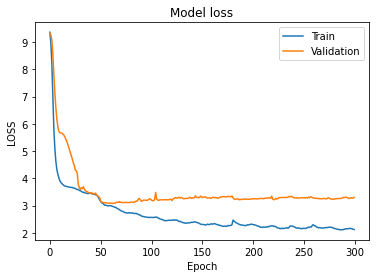

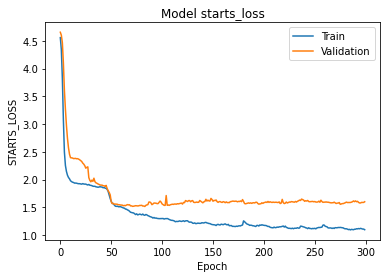

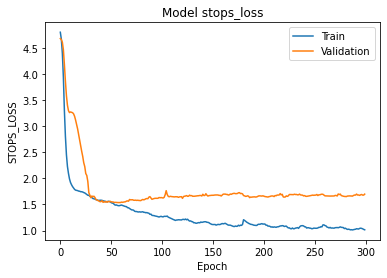

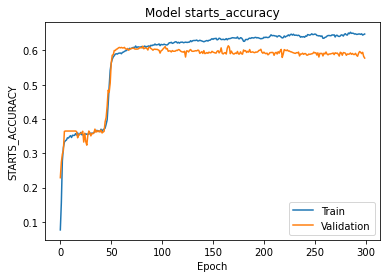

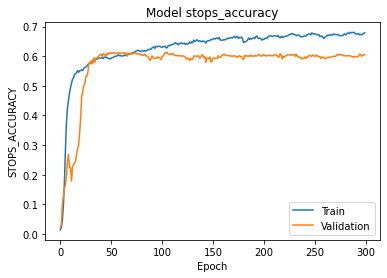

In [47]:
#metric_names = ['loss' ,'accuracy']
metric_names = ["loss", "starts_loss", "stops_loss", "starts_accuracy", "stops_accuracy"]

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

## Validation

#### Inference

In [48]:
model.save("../results/"+MODEL_PREFIX+"EndCheckpoint.h5")

In [49]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"BestCheckpoint.h5",
    compile=True
)

In [50]:
model.evaluate(x = {"att_flags":X_att_val, "words":X_val},
               y={"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)},
               batch_size=PREDICT_BATCH_SIZE)

4973/4973 [==============================] - 2s 371us/sample - loss: 3.0774 - starts_loss: 1.5199 - stops_loss: 1.5401 - starts_accuracy: 0.6075 - stops_accuracy: 0.6105


[3.0773680700086956, 1.5198622, 1.5400939, 0.6074804, 0.6104967]

In [51]:
pred_train = model.predict(x = {"att_flags":X_att_train, "words":X_train},
                           batch_size=PREDICT_BATCH_SIZE)
pred_val = model.predict(x = {"att_flags":X_att_val, "words":X_val},
                         batch_size=PREDICT_BATCH_SIZE)
pred_test = model.predict(x = {"att_flags":X_att_test, "words":X_test},
                          batch_size=PREDICT_BATCH_SIZE)

In [52]:
pred_starts_train, pred_stops_train = pred_train[0], pred_train[1]
pred_starts_val, pred_stops_val = pred_val[0], pred_val[1]
pred_starts_test, pred_stops_test = pred_test[0], pred_test[1]

In [53]:
print(pred_starts_train.shape, pred_stops_train.shape)
print(pred_starts_val.shape, pred_stops_val.shape)
print(pred_starts_test.shape, pred_stops_test.shape)

(19890, 108) (19890, 108)
(4973, 108) (4973, 108)
(3534, 108) (3534, 108)


In [54]:
preds = {
    "train":{
        "starts":{
            "y_true":Y_starts_train.argmax(axis=1),
            "y_pred":pred_starts_train.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }
    },
    "valid":{
        "starts":{
            "y_true":Y_starts_val.argmax(axis=1),
            "y_pred":pred_starts_val.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }        
    }
}

In [55]:
def print_metrics():
    funcs = [accuracy_score, f1_score, precision_score, recall_score, confusion_matrix]
    for f in funcs:
        for data_set in ["train","valid"]:
            for var in ["starts", "stops"]:
                if f in [accuracy_score]:
                    res = f(**preds[data_set][var])
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
                elif f in [confusion_matrix]:
                    res = f(**preds[data_set][var], labels = np.arange(max_len))
                    np.savetxt(X=res, fmt='%i', delimiter=",",
                               fname="../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                    print("\t||", data_set, "\t||", var, "\t||", f.__name__, "\t||", 
                          "../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                else:
                    res = f(**preds[data_set][var], average="macro")
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
        print("================================================================")

print_metrics()

61.85 	|| train 	|| starts 	|| accuracy_score
64.14 	|| train 	|| stops 	|| accuracy_score
60.75 	|| valid 	|| starts 	|| accuracy_score
64.14 	|| valid 	|| stops 	|| accuracy_score
6.14 	|| train 	|| starts 	|| f1_score
54.61 	|| train 	|| stops 	|| f1_score
5.46 	|| valid 	|| starts 	|| f1_score
54.61 	|| valid 	|| stops 	|| f1_score
7.83 	|| train 	|| starts 	|| precision_score
54.92 	|| train 	|| stops 	|| precision_score
5.65 	|| valid 	|| starts 	|| precision_score
54.92 	|| valid 	|| stops 	|| precision_score
6.60 	|| train 	|| starts 	|| recall_score
58.50 	|| train 	|| stops 	|| recall_score
6.11 	|| valid 	|| starts 	|| recall_score
58.50 	|| valid 	|| stops 	|| recall_score


c:\users\deepak\miniconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	|| train 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V15_train_starts.csv
	|| train 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V15_train_stops.csv
	|| valid 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V15_valid_starts.csv
	|| valid 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V15_valid_stops.csv


#### Postprocessing

In [56]:
Y_words_train = [tokenizer.decode(i) for i in Y_train]
Y_words_val = [tokenizer.decode(i) for i in Y_val]

In [57]:
print(pred_starts_train.shape[0],
      sum([s<e for s,e in zip(pred_starts_train.argmax(axis=1),
                              pred_stops_train.argmax(axis=1))]))
print(pred_starts_val.shape[0],
      sum([s<e for s,e in zip(pred_starts_val.argmax(axis=1),
                              pred_stops_val.argmax(axis=1))]))
print(pred_starts_test.shape[0],
      sum([s<e for s,e in zip(pred_starts_test.argmax(axis=1),
                              pred_stops_test.argmax(axis=1))]))

19890 19780
4973 4956
3534 3520


In [58]:
def post_process(string):
    string = re.sub(pattern=" (negative|positive|neutral)[ ]+$", repl="", string=string)
    string = re.sub(pattern=" +", repl=" ", string=string.strip())
    return string

In [59]:
pred_words_train = [post_process(tokenizer.decode(t[s:e])) if s<e else post_process(tokenizer.decode(t[e:])) for t, s,e in zip(X_train, pred_starts_train.argmax(axis=1), pred_stops_train.argmax(axis=1))]
pred_words_val = [post_process(tokenizer.decode(t[s:e])) if s<e else post_process(tokenizer.decode(t[e:])) for t, s,e in zip(X_val, pred_starts_val.argmax(axis=1), pred_stops_val.argmax(axis=1))]
pred_words_test = [post_process(tokenizer.decode(t[s:e])) if s<e else post_process(tokenizer.decode(t[e:])) for t, s,e in zip(X_test, pred_starts_test.argmax(axis=1), pred_stops_test.argmax(axis=1))]

In [60]:
def jaccard(str1, str2):
    a = set(str1)
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [61]:
print("Training Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_train, pred_words_train)]))
print("Validation Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_val, pred_words_val)]))

Training Jaccard Score 0.703761448202351
Validation Jaccard Score 0.6879099603285186


In [62]:
sent_labels = {i:j for i,j in enumerate(df.sentiment_code.cat.categories)}

## Submission

In [63]:
test_df['selected_text'] = pred_words_test

In [64]:
test_df[["text", "sentiment","selected_text"]].head(15)

,text,sentiment,selected_text
0,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day http://twitpic.com/67ez
1,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive,shanghai is also really exciting (precisely -- skyscrapers galore). good tweeps in china: (sh) (bj
2,"Recession hit Veronique Branquinho, she has to quit her company, such a shame!",negative,"recession hit veronique branquinho, she has to quit her company, such a shame"
3,happy bday!,positive,happy bday
4,http://twitpic.com/4w75p - I like it!!,positive,i like it
5,that`s great!! weee!! visitors!,positive,that`s great!! weee!! visitors
6,I THINK EVERYONE HATES ME ON HERE lol,negative,i think everyone hates me on here
7,"soooooo wish i could, but im in school and myspace is completely blocked",negative,"soooooo wish i could, but im in school and myspace is completely"
8,and within a short time of the last clue all of them,neutral,and within a short time of the last clue all of
9,What did you get? My day is alright.. haven`t done anything yet. leaving soon to my stepsister though!,neutral,what did you get? my day is alright.. haven`t done anything yet. leaving soon to my stepsister though


In [65]:
test_df[["textID", "selected_text"]].to_csv("../results/submission_"+MODEL_PREFIX+".csv", index=False)

In [66]:
print(ctime(time()))

Tue Apr 28 12:41:59 2020


#### Spot Checks

In [ ]:
def spot_check(index_to_check, mode):
    print("================== Sample #", index_to_check, "==================")
    if mode == "train":
        print("Selected_text:")
        print('\t', Y_words[train_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', pred_words_train[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words[train_idx[index_to_check]][num]] for num, (i,j,k) in enumerate(zip(X_train[index_to_check].tolist(),
                                                                                               pred_starts_train[index_to_check].tolist(),
                                                                                               pred_stops_train[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    elif mode == "validation":
        print("Selected_text:")
        print('\t', Y_words[val_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', pred_words_val[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words[val_idx[index_to_check]][num]] for num, (i,j,k) in enumerate(zip(X_val[index_to_check].tolist(),
                                                                                               pred_starts_val[index_to_check].tolist(),
                                                                                               pred_stops_val[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    else:
        print("Selected_text:")
        print('\t', "Not Available")
        print("Predicted_text:")
        print('\t', pred_words_test[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words_test[index_to_check][num]] for num, (i,j,k) in enumerate(zip(X_test[index_to_check].tolist(),
                                                                                               pred_starts_test[index_to_check].tolist(),
                                                                                               pred_stops_test[index_to_check].tolist())) if i!=0], sep="\n\t")

In [ ]:
for i in range(10,20):
    spot_check(i, mode="train")

In [ ]:
for i in range(200,210):
    spot_check(i, mode="validation")

In [ ]:
for i in range(0,20):
    spot_check(i, mode="test")